In [1]:
# Import packages
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem
import math
import datetime
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Set path to directory
sys.path.append("/Users/mikelgallo/repos/comp_ml/bcn_price_project") # main path to repo

In [3]:
#Import own modules
import inferences as hh
from inferences import *

In [4]:
# Load dataset
df = pd.read_csv('./train.csv')

### Variable description

1) num_rooms: # bedrooms in an apartment. (numeric)

2) num_baths: # of bathrooms in an apartment.  (numeric)

3) square_meters: total area or size of the apartment, measured in square meters. (numeric)

4) orientation: specifies the compass direction it faces or the direction in which its windows are oriented. (categorical)

5) year_built: year in which the apartment was constructed or built.(numeric)(obtain age)

6) door: Specific door number or identifier associated with the apartment within a building or complex.(obtain floor)

7) is_furnished: This variable indicates whether the apartment is offered or equipped with furniture.(boolean)(categ)

8) has_pool: Apartment has a swimming pool as part of its amenities or shared facilities.(boolean)(categorical)

9) neighborhood: Specific neighborhood or locality in which the apartment is situated within Barcelona.(Categorical)

10) num_crimes: Count or frequency of reported crimes that have occurred in the vicinity of the apartment's location.

11) has_ac: Apartment is equipped with an air conditioning system.(boolean)(categ)

12) accepts_pets: It denotes whether the apartment allows or accepts pets as tenants or residents.

13) num_supermarkets: Count or availability of supermarkets in close proximity to the apartment.

#### price: It represents the price of the apartment, typically measured in a specific currency (e.g., Euros). It is the dependent variable in the prediction task and serves as the target value to be estimated or predicted using the other variables.

In [5]:
# Shape of our dataset
df.shape

(8000, 15)

#### Interesting Features -  before preprocessing and exploration
----------------Numerical
- abs(square_meters) (good)
- age
- rooms per squaremeter
#- sqrmet per room
#- baths per rooms
- rooms per bath
- num_crimes (good)

----------------Categorical
- neighborhood (good)
- is_furnished
- age range
- floor (good)
- orientation

----------------Other potential


### Variable modification

In [6]:
#transform negative square-meters to absolute values
df['square_meters'] = df['square_meters'].abs()

In [7]:
#Floor of the apartment
df['floor'] = df['door'].str[:1]

In [20]:
# Change floor data type to numeric
df['floor'] = pd.to_numeric(df['floor'])

In [8]:
# Calculate age of apartment
df['today'] = 2023
df['age'] = df['today'] - df['year_built']

In [10]:
# Replace  True and False for 1 and 0
# Replace 'soxth' for 'south'
for i in df.columns:
    df[i] = df[i].replace('soxth','south').replace(False,0).replace(True,1)

#### Summary Statistics

In [23]:
df_diction = pop_parameters_dict(df[['num_rooms','num_baths','square_meters','age','num_crimes','price','floor']])

In [24]:
pop_parameters(df[['num_rooms','num_baths','square_meters','age','num_crimes','price','floor']])

,size,datatype,unique_values,mean,stdv,min,per25,median,per75,max,IQRs,lower_bound,upper_bound
num_rooms,8000,float64,39,2.87,5.30,1.0,1.00,2.0,4.0,97.0,3.00,0.00,8.50
num_baths,8000,float64,4,1.99,0.82,1.0,1.00,2.0,3.0,3.0,2.00,0.00,6.00
square_meters,8000,float64,145,109.16,35.37,2.0,79.00,110.0,140.0,170.0,61.00,0.00,231.50
age,8000,float64,73,37.68,20.59,2.0,20.00,38.0,55.0,73.0,35.00,0.00,107.50
num_crimes,8000,float64,12,2.80,3.45,0.0,0.00,1.0,6.0,10.0,6.00,0.00,15.00
price,8000,int64,1279,1099.62,271.67,195.0,905.75,1104.0,1295.0,2095.0,389.25,321.88,1878.88
floor,8000,float64,10,4.67,2.72,1.0,2.00,5.0,7.0,9.0,5.00,0.00,14.50


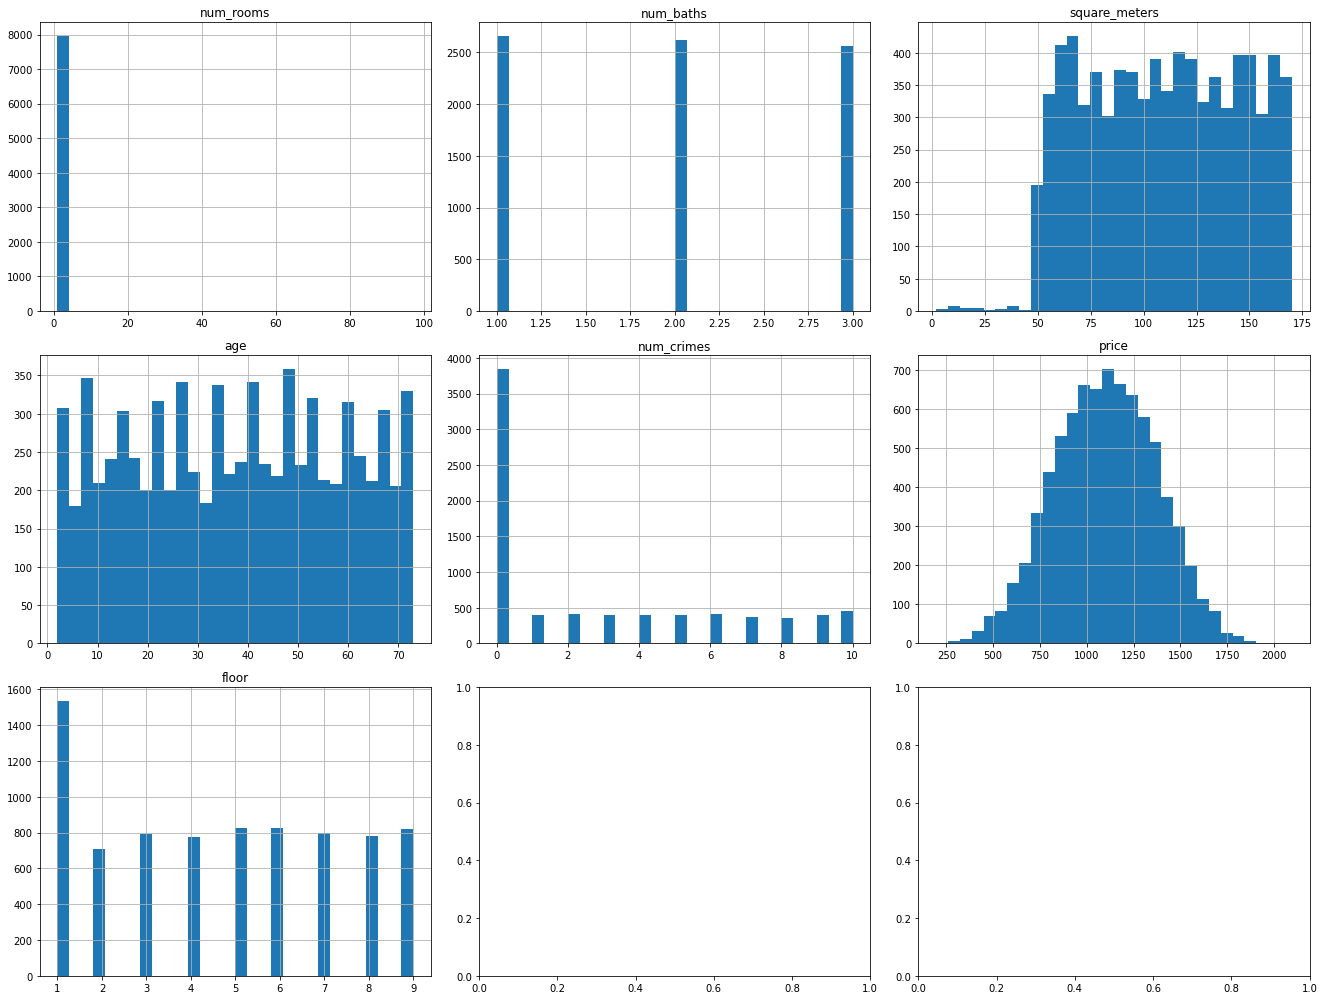

In [26]:
plot_hist_mult(df[['num_rooms','num_baths','square_meters','age','num_crimes','price','floor']],3,3,30)

### Outlier Treatment

In [28]:
# Convert outliers to missing values Number rooms
for i in df['num_rooms']:
    if i < df_diction['num_rooms']['lower_bound']:
        df['num_rooms'] = np.NaN
    if i > df_diction['num_rooms']['upper_bound']:
        df['num_rooms'] = np.NaN
    else:
        df['num_rooms'] = i

## Managing Missing Values

In [29]:
# Check for % missing values
df.isna().mean().round(2)

id                  0.00
num_rooms           0.00
num_baths           0.02
square_meters       0.02
orientation         0.29
year_built          0.02
door                0.02
is_furnished        0.02
has_pool            0.02
neighborhood        0.02
num_crimes          0.02
has_ac              0.02
accepts_pets        0.02
num_supermarkets    0.82
price               0.00
floor               0.02
today               0.00
age                 0.02
dtype: float64

<AxesSubplot:>

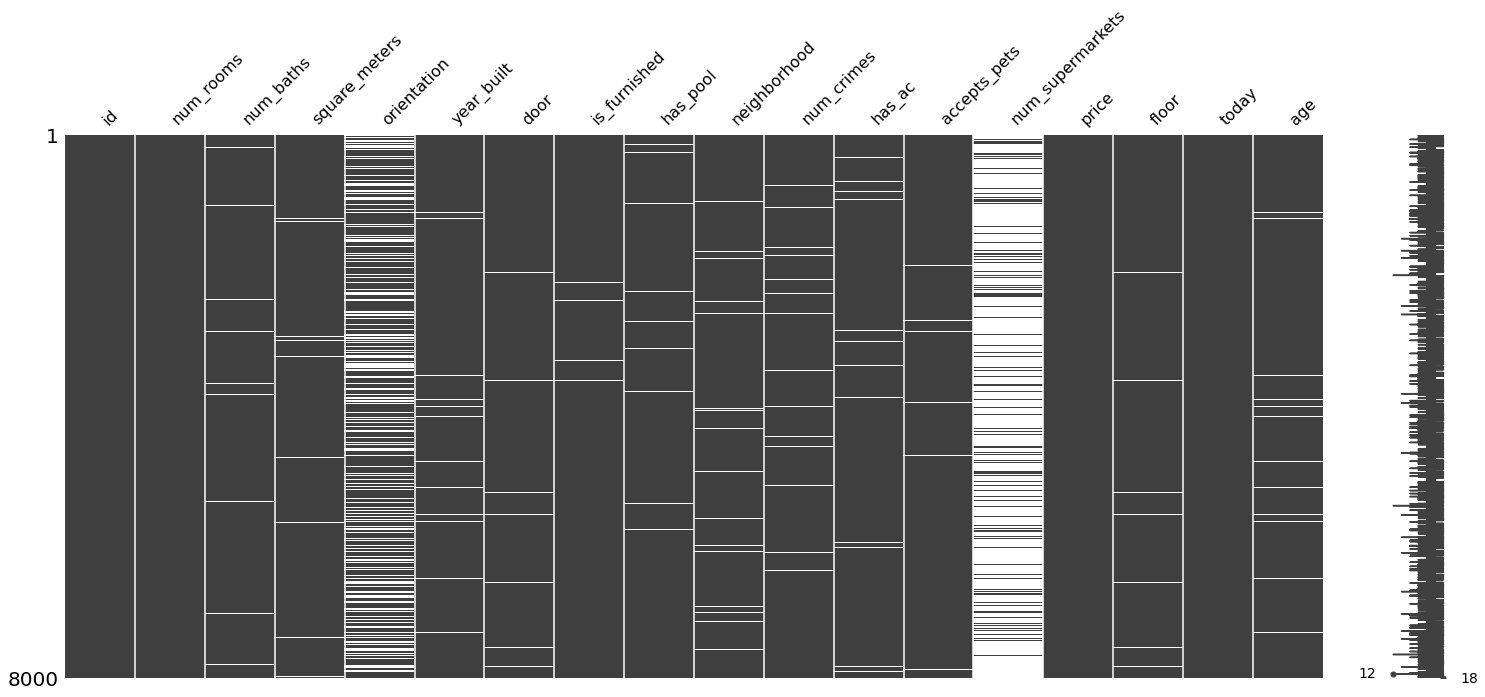

In [30]:
#  Take a look at the location of the missing values
msno.matrix(df)

### Correlation of missing values between columns

In [347]:
#msno.heatmap(df)

In [348]:
#msno.dendrogram(df)

In [31]:
df.columns

Index(['id', 'num_rooms', 'num_baths', 'square_meters', 'orientation',
       'year_built', 'door', 'is_furnished', 'has_pool', 'neighborhood',
       'num_crimes', 'has_ac', 'accepts_pets', 'num_supermarkets', 'price',
       'floor', 'today', 'age'],
      dtype='object')

In [33]:
df2 = df.copy()

### Missing Value Imputations

In [32]:
variables = ['square_meters','age','orientation','floor','num_rooms','num_baths','accepts_pets','has_pool','num_crimes','has_ac','is_furnished','price']

In [35]:
#Create impt code for orientation
df['orientation'] = df['orientation'].replace('south',1).replace('west',2).replace('north',3).replace('east',4)

In [36]:
# Perform KNN imputation
imputer = KNNImputer(n_neighbors=3)
imputed_data = imputer.fit_transform(df[variables])

# Update the original DataFrame with imputed values
df[variables] = imputed_data

In [52]:
# Check for % missing values
df.isna().mean().round(2)

id                      0.0
num_rooms               0.0
num_baths               0.0
square_meters           0.0
orientation             0.0
is_furnished            0.0
has_pool                0.0
num_crimes              0.0
has_ac                  0.0
accepts_pets            0.0
price                   0.0
floor                   0.0
age                     0.0
neighborhood_Encoded    0.0
age_range               0.0
dtype: float64

In [38]:
# Calculating the mean crime for each neighborhood
mean_crime = df.groupby('neighborhood')['num_crimes'].mean()

# Encoding the categorical variable 'Country' using target encoding
df['neighborhood_Encoded'] = df['neighborhood'].map(mean_crime)

In [40]:
# Remove Columns
df = df.drop(['today','num_supermarkets','neighborhood','door','year_built'], axis=1)

### Creating  new variables & returning orientation back to categorical

In [272]:
#Rooms per square-meter  / sqr-meter per room we've doneboth
#df['sqrmt_per_room'] = df['square_meters']/df['num_rooms']

In [248]:
#df['baths_per_room'] = df['num_baths']/df['num_rooms']

In [43]:
#New Range
df['age_range'] = np.where(df['age']<40, 'Young_building',
                   np.where(df['age']<60, 'middle_age_building',
                   np.where(df['age']<75, 'Old', 'Very Old')))

In [44]:
#Return Orientation to original values
df['orientation'] = df['orientation'].round(0)

In [46]:
#Create impt code for neighborhood
df['orientation'] = df['orientation'].replace(1,'south').replace(2,'west').replace(3,'north').replace(4,'east')

In [49]:
#Change variables again
variables = ['square_meters','age','floor','num_rooms','num_baths','accepts_pets','has_pool','num_crimes','has_ac','is_furnished','price','neighborhood_Encoded']

In [51]:
# Perform KNN imputation to obtain missing encoded neighborhood
imputer = KNNImputer(n_neighbors=3)
imputed_data = imputer.fit_transform(df[variables])

# Update the original DataFrame with imputed values
df[variables] = imputed_data

In [55]:
df

,id,num_rooms,num_baths,square_meters,orientation,is_furnished,has_pool,num_crimes,has_ac,accepts_pets,price,floor,age,neighborhood_Encoded,age_range
0,9255,1.0,1.000000,88.0,east,0.0,0.0,2.0,1.0,1.0,1096.0,3.0,67.0,3.481385,Old
1,1562,1.0,1.000000,133.0,west,0.0,0.0,4.0,0.0,0.0,1396.0,7.0,63.0,3.654111,Old
2,1671,1.0,3.000000,137.0,west,0.0,1.0,0.0,0.0,0.0,1263.0,1.0,23.0,0.953125,Young_building
3,6088,1.0,2.000000,41.0,west,0.0,1.0,5.0,0.0,0.0,1290.0,6.0,21.0,3.654111,Young_building
4,6670,1.0,1.000000,70.0,north,1.0,0.0,0.0,0.0,1.0,962.0,5.0,44.0,2.200000,middle_age_building
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,5735,1.0,2.333333,95.0,south,0.0,0.0,0.0,0.0,0.0,1066.0,9.0,2.0,3.481385,Young_building
7996,5192,1.0,3.000000,166.0,north,0.0,0.0,9.0,0.0,0.0,1255.0,9.0,28.0,5.082420,Young_building
7997,5391,1.0,1.000000,89.0,east,1.0,0.0,0.0,1.0,0.0,1220.0,9.0,8.0,3.481385,Young_building
7998,861,1.0,2.000000,167.0,west,0.0,1.0,0.0,1.0,0.0,1547.0,8.0,46.0,2.200000,middle_age_building


####  Create Dummy variables for age_range and orientation

In [57]:
# Apply one-hot encoding to orientation
dummies = pd.get_dummies(df['orientation'], prefix='o')
df = pd.concat([df.drop(columns='orientation'), dummies], axis=1)

In [60]:
# Apply one-hot encoding to age range
dummies_2 = pd.get_dummies(df['age_range'], prefix='a')
df = pd.concat([df.drop(columns='age_range'), dummies_2], axis=1)

In [61]:
df

,id,num_rooms,num_baths,square_meters,is_furnished,has_pool,num_crimes,has_ac,accepts_pets,price,floor,age,neighborhood_Encoded,o_east,o_north,o_south,o_west,a_Old,a_Young_building,a_middle_age_building
0,9255,1.0,1.000000,88.0,0.0,0.0,2.0,1.0,1.0,1096.0,3.0,67.0,3.481385,1,0,0,0,1,0,0
1,1562,1.0,1.000000,133.0,0.0,0.0,4.0,0.0,0.0,1396.0,7.0,63.0,3.654111,0,0,0,1,1,0,0
2,1671,1.0,3.000000,137.0,0.0,1.0,0.0,0.0,0.0,1263.0,1.0,23.0,0.953125,0,0,0,1,0,1,0
3,6088,1.0,2.000000,41.0,0.0,1.0,5.0,0.0,0.0,1290.0,6.0,21.0,3.654111,0,0,0,1,0,1,0
4,6670,1.0,1.000000,70.0,1.0,0.0,0.0,0.0,1.0,962.0,5.0,44.0,2.200000,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,5735,1.0,2.333333,95.0,0.0,0.0,0.0,0.0,0.0,1066.0,9.0,2.0,3.481385,0,0,1,0,0,1,0
7996,5192,1.0,3.000000,166.0,0.0,0.0,9.0,0.0,0.0,1255.0,9.0,28.0,5.082420,0,1,0,0,0,1,0
7997,5391,1.0,1.000000,89.0,1.0,0.0,0.0,1.0,0.0,1220.0,9.0,8.0,3.481385,1,0,0,0,0,1,0
7998,861,1.0,2.000000,167.0,0.0,1.0,0.0,1.0,0.0,1547.0,8.0,46.0,2.200000,0,0,0,1,0,0,1


## Bivariate Analysis

In [55]:
# Check Data Type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8000 non-null   int64  
 1   num_rooms         8000 non-null   float64
 2   num_baths         7840 non-null   float64
 3   square_meters     7845 non-null   float64
 4   orientation       5659 non-null   object 
 5   year_built        7830 non-null   float64
 6   door              7851 non-null   object 
 7   is_furnished      7835 non-null   float64
 8   has_pool          7844 non-null   float64
 9   neighborhood      7835 non-null   object 
 10  num_crimes        7840 non-null   float64
 11  has_ac            7831 non-null   float64
 12  accepts_pets      7845 non-null   float64
 13  num_supermarkets  1411 non-null   float64
 14  price             8000 non-null   int64  
dtypes: float64(10), int64(2), object(3)
memory usage: 937.6+ KB


In [49]:
#Calculating the unique values for each column
diction = {}
for i in df.columns:
    unique_vals = np.size(df[i].unique())
    diction[i] = unique_vals
print(pd.DataFrame.from_dict(diction,orient ='index'))

                     0
id                8000
num_rooms           39
num_baths            4
square_meters      179
orientation          6
year_built          73
door                41
is_furnished         3
has_pool             3
neighborhood        11
num_crimes          12
has_ac               3
accepts_pets         3
num_supermarkets     4
price             1279


### Exploring Categorical data

Step 1 - Check all our categorical data

In [230]:
# Creating  a  subset  of  categorical  data
categoricals = ['orientation','is_furnished','has_pool','neighborhood','has_ac','accepts_pets','floor']

In [231]:
for i in df[categoricals].columns:
    a = df[categoricals][i].unique()
    print(i)
    print(a)

orientation
[nan 'west' 'east' 'north' 'south']
is_furnished
[ 0.  1. nan]
has_pool
[ 0.  1. nan]
neighborhood
['Sant Martí' 'Sants' 'Eixample' 'Gràcia' nan 'Les Cors'
 'Sarrià-Sant Gervasi' 'Horta' 'Sant Andreu' 'Ciutat Vella' 'Nou Barris']
has_ac
[ 1.  0. nan]
accepts_pets
[ 1.  0. nan]
floor
['3' '7' '1' '6' '5' nan '2' '8' '4' '9']


In [232]:
# Category proportion %
for i in df[categoricals].columns:
    counts = pd.DataFrame(df[i].value_counts()/df[i].count()).reset_index()
    print(counts)

   index  orientation
0   west     0.258173
1  north     0.250574
2   east     0.247570
3  south     0.243683
   index  is_furnished
0    0.0      0.518315
1    1.0      0.481685
   index  has_pool
0    1.0  0.504207
1    0.0  0.495793
                 index  neighborhood
0                Sants      0.105041
1           Nou Barris      0.104786
2               Gràcia      0.103382
3          Sant Andreu      0.101213
4         Ciutat Vella      0.101213
5           Sant Martí      0.098277
6             Eixample      0.098022
7  Sarrià-Sant Gervasi      0.097128
8                Horta      0.095980
9             Les Cors      0.094959
   index    has_ac
0    1.0  0.504406
1    0.0  0.495594
   index  accepts_pets
0    1.0      0.507967
1    0.0      0.492033
  index     floor
0     1  0.195516
1     5  0.105210
2     6  0.105082
3     9  0.104191
4     7  0.101261
5     3  0.100624
6     8  0.099223
7     4  0.098714
8     2  0.090180


- Orientation: Sample of apartments is well balanced in terms of orientation (~25% each category)
- is_furnished: Half apartments are  furnished
- has_pool: Half apartments have pool
- neighborhood: Sample of apartments is well balanced in terms of neighborhood (~10% each category)
- has_ac: Half apartments have ac
- accepts_pets: half apartments accept pets

### Studying the neighborhoods

In [368]:
df.columns

Index(['id', 'num_rooms', 'num_baths', 'square_meters', 'orientation',
       'year_built', 'door', 'is_furnished', 'has_pool', 'neighborhood',
       'num_crimes', 'has_ac', 'accepts_pets', 'num_supermarkets', 'price',
       'age', 'today', 'floor', 'rooms_per_sqrtmt', 'baths_per_room',
       'sqrmt_per_room', 'age_range'],
      dtype='object')

In [274]:
variables = ['price', 'num_crimes','square_meters','num_rooms','num_baths','age','rooms_per_sqrtmt','baths_per_room','sqrmt_per_room']

In [275]:
ng_price_vs_crime = df.groupby(['neighborhood'])[variables].mean().sort_values(by='price',ascending = False).round(3).reset_index()

In [276]:
ng_price_vs_crime

,neighborhood,price,num_crimes,square_meters,num_rooms,num_baths,age,rooms_per_sqrtmt,baths_per_room,sqrmt_per_room
0,Sarrià-Sant Gervasi,1151.980,0.628,109.950,2.926,1.996,37.859,0.031,1.042,56.722
1,Eixample,1143.737,0.921,109.134,2.836,2.025,36.760,0.029,1.059,57.384
2,Les Cors,1127.503,1.429,108.127,2.938,1.973,37.371,0.030,1.026,56.109
3,Gràcia,1117.152,2.215,109.339,2.942,1.985,38.220,0.031,1.049,57.230
4,Horta,1108.239,2.541,109.404,2.806,1.954,38.520,0.029,1.007,55.893
5,Ciutat Vella,1096.231,3.077,109.849,2.666,1.982,37.217,0.027,1.046,58.764
6,Sants,1088.028,3.673,111.133,2.772,1.989,37.414,0.029,1.047,57.858
7,Sant Martí,1067.832,3.497,107.201,3.186,1.971,37.602,0.032,1.034,55.250
8,Sant Andreu,1067.313,4.488,110.532,2.589,2.027,38.397,0.030,1.030,57.291
9,Nou Barris,1038.453,5.119,107.197,2.998,1.975,37.557,0.032,1.016,55.246


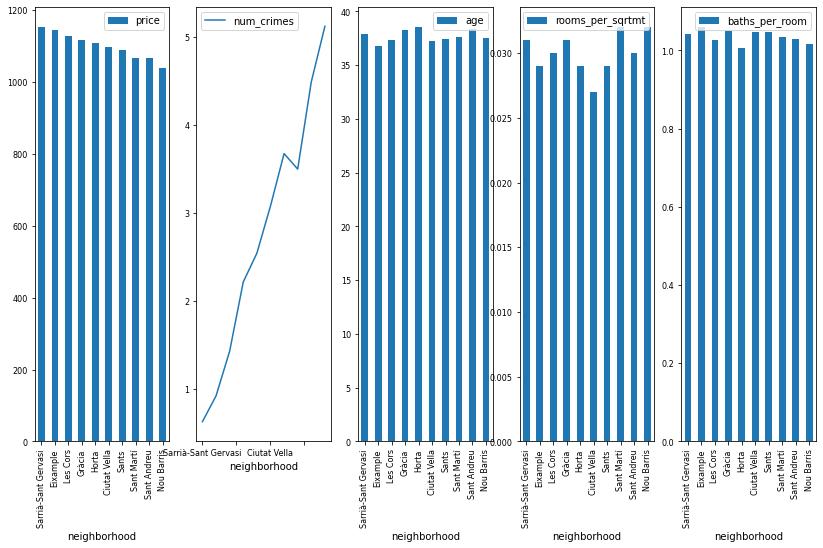

In [279]:
#Plotting both perc and accum
#Plot both mean  and median as lines
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14,8))
ng_price_vs_crime.plot(x='neighborhood', y='price' , kind= 'bar', ax=ax1,fontsize=8)
ng_price_vs_crime.plot(x='neighborhood', y='num_crimes', kind = 'line',ax = ax2,fontsize=8)
ng_price_vs_crime.plot(x='neighborhood', y='age' , kind= 'bar', ax=ax3,fontsize=8)
ng_price_vs_crime.plot(x='neighborhood', y='rooms_per_sqrtmt' , kind= 'bar', ax=ax4,fontsize=8)
ng_price_vs_crime.plot(x='neighborhood', y='baths_per_room' , kind= 'bar', ax=ax5,fontsize=8)

plt.xticks(rotation=90)
plt.show()

Price is influenced by the neighborhood. Most importantly by the crime_rate. The lower the crime rate, the larger the prices 

In [330]:
#  Calculating Frequency tables
frq_table_1 = pd.crosstab(index=df['neighborhood'].astype(str), columns= df['is_furnished'].astype(str),
                        normalize ='index', margins=False).round(2)

### Studying the Apartment Floor

In [308]:
df.columns

Index(['id', 'num_rooms', 'num_baths', 'square_meters', 'orientation',
       'year_built', 'door', 'is_furnished', 'has_pool', 'neighborhood',
       'num_crimes', 'has_ac', 'accepts_pets', 'num_supermarkets', 'price',
       'age', 'today', 'floor', 'rooms_per_sqrtmt', 'baths_per_room',
       'sqrmt_per_room'],
      dtype='object')

In [303]:
f_price_v = df.groupby(['floor'])[variables].mean().sort_values(by='price',ascending = False).round(3).reset_index()

In [304]:
f_price_v

,floor,price,num_crimes,square_meters,num_rooms,num_baths,age,rooms_per_sqrtmt,baths_per_room,sqrmt_per_room
0,9,1132.555,2.870,109.576,2.903,2.021,37.733,0.031,1.029,55.310
1,7,1128.077,2.892,111.265,2.850,1.996,36.985,0.031,1.042,58.030
2,8,1123.154,2.708,108.146,2.923,2.046,36.832,0.029,1.055,56.014
3,6,1112.515,2.605,108.615,2.834,1.978,38.552,0.030,1.014,56.456
4,1,1096.677,2.863,108.789,2.849,1.975,37.659,0.029,1.039,57.021
5,4,1092.399,2.692,109.600,2.631,2.039,38.016,0.029,1.093,58.177
6,5,1088.346,2.744,108.313,2.741,1.948,37.502,0.028,1.038,56.822
7,3,1064.928,3.017,109.447,3.056,1.953,39.503,0.031,1.016,57.479
8,2,1051.486,2.782,109.155,3.130,1.967,36.209,0.035,1.015,55.850


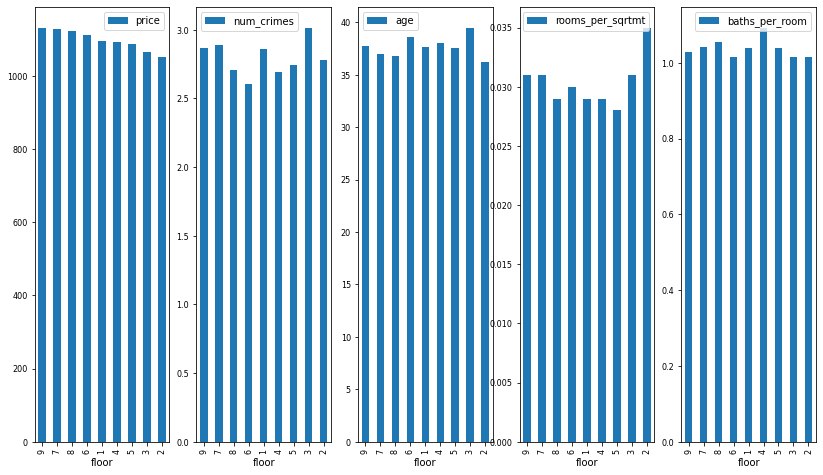

In [305]:
#Plot both mean  and median as lines
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14,8))
f_price_v.plot(x='floor', y='price' , kind= 'bar', ax=ax1,fontsize=8)
f_price_v.plot(x='floor', y='num_crimes', kind = 'bar',ax = ax2,fontsize=8)
f_price_v.plot(x='floor', y='age' , kind= 'bar', ax=ax3,fontsize=8)
f_price_v.plot(x='floor', y='rooms_per_sqrtmt' , kind= 'bar', ax=ax4,fontsize=8)
f_price_v.plot(x='floor', y='baths_per_room' , kind= 'bar', ax=ax5,fontsize=8)

plt.xticks(rotation=90)
plt.show()

Clear pattern shows that higher floors have more weight on the apartment price

In [338]:
#  Calculating Frequency tables
frq_table_1 = pd.crosstab(index=df['floor'].astype(str), columns= df['age_range'].astype(str),
                        normalize ='index', margins=False).round(2)

### Studying Age

In [341]:
df.columns

Index(['id', 'num_rooms', 'num_baths', 'square_meters', 'orientation',
       'year_built', 'door', 'is_furnished', 'has_pool', 'neighborhood',
       'num_crimes', 'has_ac', 'accepts_pets', 'num_supermarkets', 'price',
       'age', 'today', 'floor', 'rooms_per_sqrtmt', 'baths_per_room',
       'sqrmt_per_room', 'age_range'],
      dtype='object')

In [345]:
A_price_v = df.groupby(['age_range'])[variables].mean().sort_values(by='price',ascending = False).round(3).reset_index()

In [346]:
A_price_v

,age_range,price,num_crimes,square_meters,num_rooms,num_baths,age,rooms_per_sqrtmt,baths_per_room,sqrmt_per_room
0,Old,1107.272,2.678,109.698,2.907,1.961,66.478,0.030,1.028,57.528
1,Very Old,1100.576,2.988,108.571,2.935,2.145,NaN,0.030,1.074,52.361
2,middle_age_building,1100.453,2.893,110.237,3.000,2.007,49.311,0.031,1.053,57.265
3,Young_building,1096.299,2.793,108.394,2.780,1.982,20.717,0.029,1.029,56.412


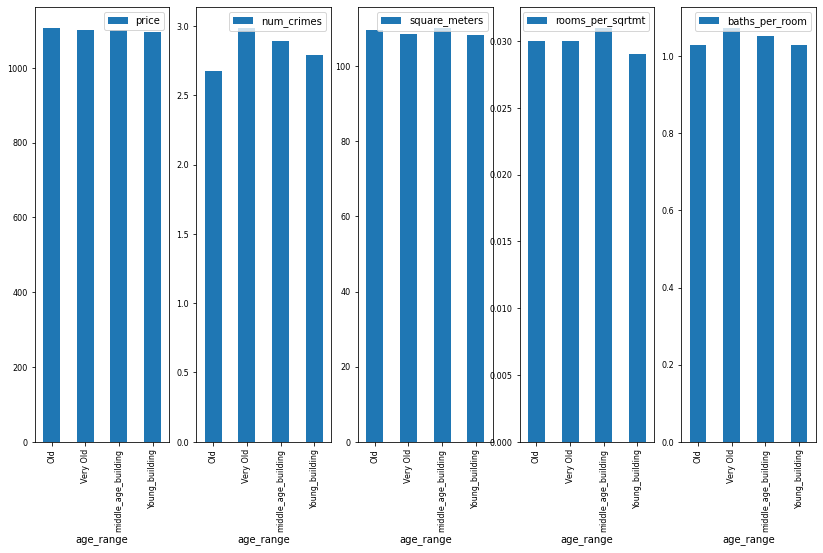

In [363]:
#Plot both mean  and median as lines
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14,8))
A_price_v.plot(x='age_range', y='price' , kind= 'bar', ax=ax1,fontsize=8)
A_price_v.plot(x='age_range', y='num_crimes', kind = 'bar',ax = ax2,fontsize=8)
A_price_v.plot(x='age_range', y='square_meters' , kind= 'bar', ax=ax3,fontsize=8)
A_price_v.plot(x='age_range', y='rooms_per_sqrtmt' , kind= 'bar', ax=ax4,fontsize=8)
A_price_v.plot(x='age_range', y='baths_per_room' , kind= 'bar', ax=ax5,fontsize=8)

plt.xticks(rotation=90)
plt.show()

### Studying Orientation

In [372]:
df.columns

Index(['id', 'num_rooms', 'num_baths', 'square_meters', 'orientation',
       'year_built', 'door', 'is_furnished', 'has_pool', 'neighborhood',
       'num_crimes', 'has_ac', 'accepts_pets', 'num_supermarkets', 'price',
       'age', 'today', 'floor', 'rooms_per_sqrtmt', 'baths_per_room',
       'sqrmt_per_room', 'age_range'],
      dtype='object')

In [373]:
o_price_v = df.groupby(['orientation'])[variables].mean().sort_values(by='price',ascending = False).round(3).reset_index()

In [374]:
o_price_v

,orientation,price,num_crimes,square_meters,num_rooms,num_baths,age,rooms_per_sqrtmt,baths_per_room,sqrmt_per_room
0,south,1102.145,2.802,109.839,3.007,1.979,38.410,0.031,1.025,57.240
1,west,1098.560,2.919,109.328,2.953,2.003,38.650,0.031,1.036,56.130
2,north,1096.452,2.593,107.677,2.836,1.965,37.595,0.030,0.999,54.685
3,east,1093.642,2.809,107.620,2.794,1.985,37.035,0.030,1.050,56.513


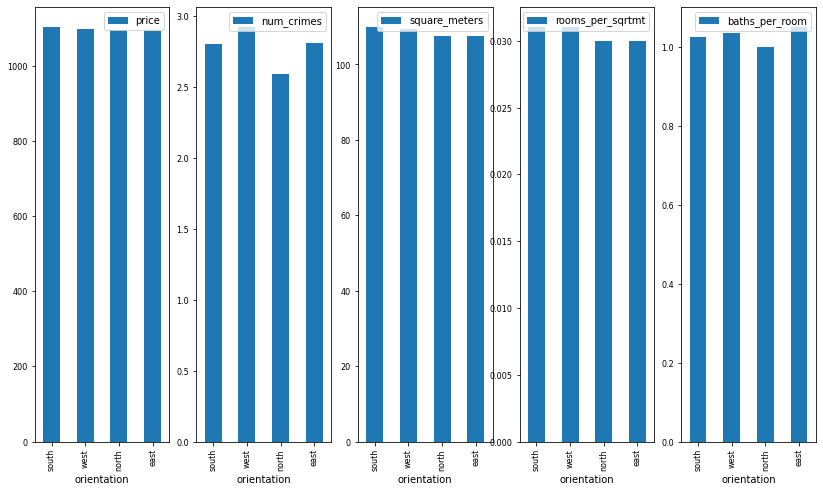

In [375]:
#Plot both mean  and median as lines
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14,8))
o_price_v.plot(x='orientation', y='price' , kind= 'bar', ax=ax1,fontsize=8)
o_price_v.plot(x='orientation', y='num_crimes', kind = 'bar',ax = ax2,fontsize=8)
o_price_v.plot(x='orientation', y='square_meters' , kind= 'bar', ax=ax3,fontsize=8)
o_price_v.plot(x='orientation', y='rooms_per_sqrtmt' , kind= 'bar', ax=ax4,fontsize=8)
o_price_v.plot(x='orientation', y='baths_per_room' , kind= 'bar', ax=ax5,fontsize=8)

plt.xticks(rotation=90)
plt.show()

In [340]:
df.corr()

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,num_crimes,has_ac,accepts_pets,num_supermarkets,price,age,today,rooms_per_sqrtmt,baths_per_room,sqrmt_per_room
id,1.000000,0.033887,0.004186,0.011568,0.011605,0.012929,-0.005120,0.010191,-0.007099,-0.001318,-0.010118,0.005516,-0.011605,NaN,0.024768,-0.010461,-0.003422
num_rooms,0.033887,1.000000,-0.008784,0.022802,-0.009523,0.006898,0.002485,0.000581,-0.010446,0.004351,-0.022344,0.030654,0.009523,NaN,0.813980,-0.244018,-0.264580
num_baths,0.004186,-0.008784,1.000000,0.004245,0.008388,0.010869,-0.011858,0.018222,0.010213,0.011946,-0.026240,0.026952,-0.008388,NaN,-0.007641,0.559803,-0.003941
square_meters,0.011568,0.022802,0.004245,1.000000,-0.022595,0.007708,-0.015135,-0.012313,-0.028949,-0.003776,0.006816,0.707714,0.022595,NaN,-0.180756,-0.010510,0.467292
year_built,0.011605,-0.009523,0.008388,-0.022595,1.000000,0.009032,-0.028828,0.002578,-0.016443,-0.001663,0.023443,-0.017782,-1.000000,NaN,-0.003036,-0.004410,-0.022945
is_furnished,0.012929,0.006898,0.010869,0.007708,0.009032,1.000000,0.002436,0.005122,-0.011943,-0.001668,0.041610,0.007295,-0.009032,NaN,0.008436,-0.004755,0.000624
has_pool,-0.005120,0.002485,-0.011858,-0.015135,-0.028828,0.002436,1.000000,-0.004809,0.005457,0.002108,0.036638,0.001067,0.028828,NaN,0.004032,-0.021057,-0.019854
num_crimes,0.010191,0.000581,0.018222,-0.012313,0.002578,0.005122,-0.004809,1.000000,0.003376,0.021108,0.022389,-0.290954,-0.002578,NaN,0.001480,0.008090,-0.008340
has_ac,-0.007099,-0.010446,0.010213,-0.028949,-0.016443,-0.011943,0.005457,0.003376,1.000000,0.009490,-0.024399,-0.007391,0.016443,NaN,-0.007569,0.005888,-0.016035
accepts_pets,-0.001318,0.004351,0.011946,-0.003776,-0.001663,-0.001668,0.002108,0.021108,0.009490,1.000000,0.006530,-0.010619,0.001663,NaN,0.014850,0.004468,-0.001282


In [352]:
lista = df.describe().columns

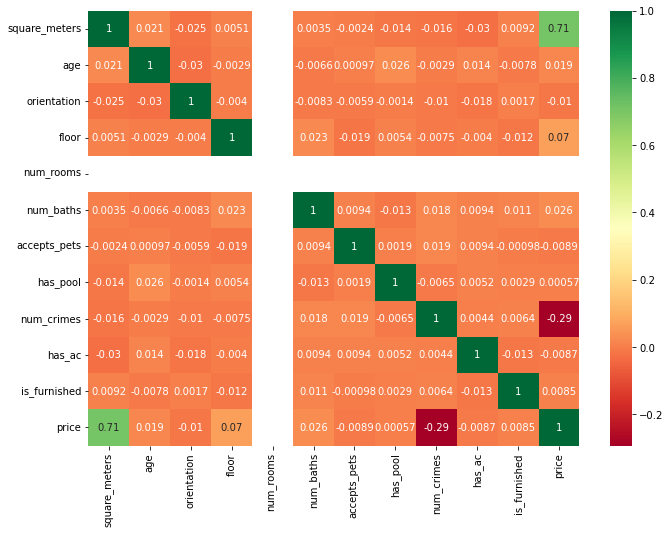

In [525]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df[variables].corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, cmap="RdYlGn", annot=True)
plt.show()
